In [120]:
import os
import sys
import json
import pytz
import random
import datetime
import dateutil
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
from joblib import Parallel,delayed

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
BINANCE_ROOT_PATH = 'https://www.binance.com'

# Glossary

In [3]:
"""

symbol : BTCUSDT

BTC - quoted asset (котируемый инструмент)
USDT - fiat asset (фиатный инструмент)

When we buy symbol BTCUSDT, we sell our USDT and receive BTC in exchange
When we sell symbol BTCUSDT, we sell our BTC and receive USD in exchange


"""

'\n\nsymbol : BTCUSDT\n\nBTC - quoted asset (котируемый инструмент)\nUSDT - fiat asset (фиатный инструмент)\n\nWhen we buy symbol BTCUSDT, we sell our USDT and receive BTC in exchange\nWhen we sell symbol BTCUSDT, we sell our BTC and receive USD in exchange\n\n\n'

# Request order book

In [4]:
"""
From https://binance-docs.github.io/apidocs/spot/en/#exchange-information

Order Book

GET /api/v3/depth

Weight(IP):

Adjusted based on the limit:

Limit	Weight
1-100	5
101-500	25
501-1000	50
1001-5000	250
Parameters:

Name	Type	Mandatory	Description
symbol	STRING	YES	
limit	INT	NO	Default 100; max 5000.

If limit > 5000, then the response will truncate to 5000.
Data Source: Memory
"""
print ()

In [5]:
R = requests.get(
    url = os.path.join(BINANCE_ROOT_PATH,'api/v3/depth'),
    params = {
        'symbol' : 'BTCUSDT',
        'limit' : 5000
    }
)

In [6]:
R.ok

True

In [7]:
R.status_code

200

In [8]:
R.reason

'OK'

In [9]:
result = json.loads(R.text)

In [10]:
result = R.json() # equivalent implementation of json.loads(R.text)

In [11]:
type(result)

dict

In [12]:
result.keys()

dict_keys(['lastUpdateId', 'bids', 'asks'])

In [13]:
result['lastUpdateId']

39778563043

In [14]:
type(result['bids'])

list

In [15]:
len(result['bids'])

5000

In [16]:
bids = pd.DataFrame(result['bids'],columns=['price','amount'])

In [17]:
bids.dtypes

price     object
amount    object
dtype: object

In [18]:
bids = pd.DataFrame(result['bids'],columns=['price','amount']).astype(float)

In [19]:
bids.dtypes

price     float64
amount    float64
dtype: object

In [20]:
asks = pd.DataFrame(result['asks'],columns=['price','amount']).astype(float)

In [21]:
bids

,price,amount
0,34093.41,5.73753
1,34093.18,0.00908
2,34093.11,0.00122
3,34093.06,0.00022
4,34093.03,0.00065
...,...,...
4995,33386.74,0.00548
4996,33386.63,0.00360
4997,33386.36,0.00071
4998,33386.19,0.00184


In [22]:
asks

,price,amount
0,34093.42,5.89919
1,34093.46,0.29335
2,34093.56,0.29335
3,34093.77,0.06972
4,34093.78,0.00022
...,...,...
4995,34795.16,0.00181
4996,34795.27,0.00148
4997,34795.50,0.00030
4998,34795.79,0.00021


Idea: taken max depth orderbook, plot cumulative distribution of relative volume (with regard to the total volume) concentrated in the orderbook based on the level

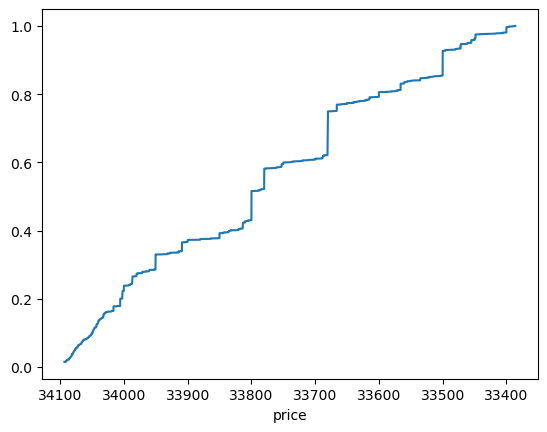

In [23]:
ax = ( bids.set_index('price').amount.cumsum() / bids.set_index('price').amount.sum() ).plot()
ax.invert_xaxis()

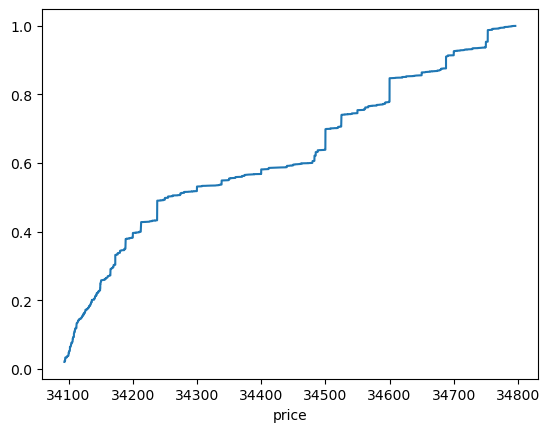

In [24]:
ax = ( asks.set_index('price').amount.cumsum() / asks.set_index('price').amount.sum() ).plot()

Question #2 :
each 10% of relative volume identify relative price level as change from best bid / ask

In [25]:
# Example for bid, 0.1

bid_amount = bids.set_index('price').amount
rel_cum_bid_amount = bid_amount.cumsum()/bid_amount.sum()
rel_cum_bid_amount[rel_cum_bid_amount >= 0.1].index[0] / bid_amount.index[0] - 1

-0.0012967315384412315

In [26]:
"""
10% of total bid volume: on which price we reach it?
20% ...

As result, we have a time series which has a following structure:
    
0.1 : -0.00037486630528371645
0.2 : 
0.3 : 
0.4 : 
...
0.9 : 
1.0 : 

"""

'\n10% of total bid volume: on which price we reach it?\n20% ...\n\nAs result, we have a time series which has a following structure:\n    \n0.1 : -0.00037486630528371645\n0.2 : \n0.3 : \n0.4 : \n...\n0.9 : \n1.0 : \n\n'

In [27]:
bid_amount = bids.set_index('price').amount
rel_cum_bid_amount = bid_amount.cumsum()/bid_amount.sum()
bid_grid = dict()
for t in np.arange(0.1,1.1,0.1):
    bid_grid[t] = rel_cum_bid_amount[rel_cum_bid_amount >= t].index[0] / bid_amount.index[0] - 1

ask_amount = asks.set_index('price').amount
rel_cum_ask_amount = ask_amount.cumsum()/ask_amount.sum()
ask_grid = dict()
for t in np.arange(0.1,1.1,0.1):
    ask_grid[t] = rel_cum_ask_amount[rel_cum_ask_amount >= t].index[0] / ask_amount.index[0] - 1

In [28]:
pd.Series(bid_grid)

0.1   -0.001297
0.2   -0.002570
0.3   -0.004198
0.4   -0.007659
0.5   -0.008606
0.6   -0.010261
0.7   -0.012126
0.8   -0.014472
0.9   -0.017405
1.0   -0.020749
dtype: float64

In [29]:
pd.Series(ask_grid)

0.1    0.000436
0.2    0.001259
0.3    0.002246
0.4    0.003504
0.5    0.004739
0.6    0.011194
0.7    0.012160
0.8    0.014859
0.9    0.017440
1.0    0.020605
dtype: float64

In [34]:
bid_cum_rel_vol = dict()
for t in np.arange(0.0005,0.0205,0.0005):
    bid_cum_rel_vol[t] = bids.loc[bids.price >=(1-t)*bids.price[0]].amount.sum() / bids.amount.sum()
bid_cum_rel_vol = pd.Series(bid_cum_rel_vol)
# bid_cum_rel_vol.plot()

ask_cum_rel_vol = dict()
for t in np.arange(0.0005,0.0205,0.0005):
    ask_cum_rel_vol[t] = asks.loc[asks.price <=(1+t)*asks.price[0]].amount.sum() / asks.amount.sum()
ask_cum_rel_vol = pd.Series(ask_cum_rel_vol)
# ask_cum_rel_vol.plot()

In [35]:
bid_cum_rel_vol

0.0005    0.052375
0.0010    0.080927
0.0015    0.125647
0.0020    0.161985
0.0025    0.178760
0.0030    0.240461
0.0035    0.274986
0.0040    0.284529
0.0045    0.330322
0.0050    0.335024
0.0055    0.365497
0.0060    0.372795
0.0065    0.375318
0.0070    0.377388
0.0075    0.394840
0.0080    0.401301
0.0085    0.429789
0.0090    0.517975
0.0095    0.582769
0.0100    0.594841
0.0105    0.601863
0.0110    0.605765
0.0115    0.607844
0.0120    0.620845
0.0125    0.750635
0.0130    0.772035
0.0135    0.778513
0.0140    0.783789
0.0145    0.805869
0.0150    0.807290
0.0155    0.830684
0.0160    0.839466
0.0165    0.847087
0.0170    0.851869
0.0175    0.927101
0.0180    0.932229
0.0185    0.947236
0.0190    0.975164
0.0195    0.976569
0.0200    0.978657
dtype: float64

In [36]:
ask_cum_rel_vol

0.0005    0.116934
0.0010    0.172182
0.0015    0.220725
0.0020    0.270541
0.0025    0.337944
0.0030    0.381436
0.0035    0.399735
0.0040    0.430543
0.0045    0.491628
0.0050    0.505595
0.0055    0.515814
0.0060    0.518062
0.0065    0.533869
0.0070    0.535199
0.0075    0.550152
0.0080    0.559574
0.0085    0.566611
0.0090    0.581553
0.0095    0.586154
0.0100    0.587393
0.0105    0.595708
0.0110    0.599379
0.0115    0.631993
0.0120    0.699554
0.0125    0.702736
0.0130    0.742752
0.0135    0.754419
0.0140    0.766607
0.0145    0.770595
0.0150    0.848000
0.0155    0.851160
0.0160    0.854274
0.0165    0.865615
0.0170    0.868419
0.0175    0.912322
0.0180    0.927816
0.0185    0.931914
0.0190    0.935996
0.0195    0.988421
0.0200    0.994817
dtype: float64

Let's implement method which requests orderbook

In [89]:
def request_orderbook(symbol,limit=5000):
    R = requests.get(
        url = os.path.join(BINANCE_ROOT_PATH,'api/v3/depth'),
        params = {
            'symbol' : symbol,
            'limit' : limit
        }
    )
    result = R.json()
    
    bids = pd.DataFrame(result['bids'],columns=['price','amount']).astype(float)
    asks = pd.DataFrame(result['asks'],columns=['price','amount']).astype(float)
    return bids,asks

def cumulative_orderbook(bids,asks,relative=False):
    bids,asks = deepcopy(bids),deepcopy(asks)
    bids['amount'] = bids['amount'].cumsum()
    asks['amount'] = asks['amount'].cumsum()
    if relative:
        bids['amount'] /= bids['amount'].iloc[-1]
        asks['amount'] /= asks['amount'].iloc[-1]
    return bids,asks

def price_grid(cum_rel_bids,cum_rel_asks,end=0.02,step=0.0005):
    # cum_rel_bids & cum_rel_asks - cumulative relative amounts
    
    bids_pgrid = dict()
    for t in np.arange(0.,end+step,step):
        bids_pgrid[t] = cum_rel_bids.loc[cum_rel_bids.price >=(1-t)*cum_rel_bids.price[0]].amount.iloc[-1]
    bids_pgrid = pd.Series(bids_pgrid)
    
    asks_pgrid = dict()
    for t in np.arange(0.,end+step,step):
        asks_pgrid[t] = cum_rel_asks.loc[cum_rel_asks.price <=(1+t)*cum_rel_asks.price[0]].amount.iloc[-1]
    asks_pgrid = pd.Series(asks_pgrid)
    
    return bids_pgrid,asks_pgrid

def volume_grid(cum_rel_bids,cum_rel_asks,step=0.05):
    # cum_rel_bids & cum_rel_asks - cumulative relative amounts
    
    bids_vgrid = dict()
    for t in np.arange(step,1.+step,step):
        bids_vgrid[t] = cum_rel_bids[cum_rel_bids.amount>=t].price.iloc[0]
    bids_vgrid = pd.Series(bids_vgrid)
    
    asks_vgrid = dict()
    for t in np.arange(step,1.+step,step):
        asks_vgrid[t] = cum_rel_asks[cum_rel_asks.amount>=t].price.iloc[0]
    asks_vgrid = pd.Series(asks_vgrid)
    
    return bids_vgrid,asks_vgrid

In [94]:
bids,asks = request_orderbook('BTCUSDT')
cum_rel_bids,cum_rel_asks = cumulative_orderbook(bids,asks,relative=True)
bids_pgrid,asks_pgrid = price_grid(cum_rel_bids,cum_rel_asks)
bids_vgrid,asks_vgrid = volume_grid(cum_rel_bids,cum_rel_asks)

In [107]:
bids_pgrid.rename('BTCUSD')

0.0000    0.009013
0.0005    0.194060
0.0010    0.237225
0.0015    0.262715
0.0020    0.294956
0.0025    0.321755
0.0030    0.343295
0.0035    0.358514
0.0040    0.390314
0.0045    0.397404
0.0050    0.400517
0.0055    0.483994
0.0060    0.533116
0.0065    0.535355
0.0070    0.550043
0.0075    0.551540
0.0080    0.558683
0.0085    0.565914
0.0090    0.653830
0.0095    0.669401
0.0100    0.686525
0.0105    0.689159
0.0110    0.724945
0.0115    0.756419
0.0120    0.764879
0.0125    0.784653
0.0130    0.850955
0.0135    0.865104
0.0140    0.867538
0.0145    0.927731
0.0150    0.933277
0.0155    0.940221
0.0160    0.950495
0.0165    0.953131
0.0170    0.956148
0.0175    0.987795
0.0180    0.993454
0.0185    0.998919
0.0190    1.000000
0.0195    1.000000
0.0200    1.000000
Name: BTCUSD, dtype: float64

# Request list of all tradable instruments

In [37]:
R = requests.get(
    url = os.path.join(BINANCE_ROOT_PATH,'api/v3/exchangeInfo')
)

In [39]:
result = R.json()

In [40]:
result.keys()

dict_keys(['timezone', 'serverTime', 'rateLimits', 'exchangeFilters', 'symbols'])

In [42]:
len(result['symbols'])

2319

In [48]:
instruments = pd.DataFrame([(item['symbol'],item['status'],item['baseAsset'],item['quoteAsset']) for item in result['symbols']],columns=['symbol','status','baseAsset','quoteAsset'])

In [50]:
instruments['status'].unique()

array(['TRADING', 'BREAK'], dtype=object)

In [51]:
instruments[instruments['status']=='BREAK']

,symbol,status,baseAsset,quoteAsset
8,BCCBTC,BREAK,BCC,BTC
13,HSRBTC,BREAK,HSR,BTC
14,OAXETH,BREAK,OAX,ETH
15,DNTETH,BREAK,DNT,ETH
16,MCOETH,BREAK,MCO,ETH
...,...,...,...,...
2116,QKCBUSD,BREAK,QKC,BUSD
2119,OSMOBUSD,BREAK,OSMO,BUSD
2125,VITEBUSD,BREAK,VITE,BUSD
2141,GFTBUSD,BREAK,GFT,BUSD


In [52]:
instruments[instruments['status']=='TRADING']

,symbol,status,baseAsset,quoteAsset
0,ETHBTC,TRADING,ETH,BTC
1,LTCBTC,TRADING,LTC,BTC
2,BNBBTC,TRADING,BNB,BTC
3,NEOBTC,TRADING,NEO,BTC
4,QTUMETH,TRADING,QTUM,ETH
...,...,...,...,...
2314,AVAXFDUSD,TRADING,AVAX,FDUSD
2315,BANDTRY,TRADING,BAND,TRY
2316,BCHFDUSD,TRADING,BCH,FDUSD
2317,LOOMTRY,TRADING,LOOM,TRY


In [53]:
instruments[(instruments['status']=='TRADING')&(instruments['quoteAsset']=='USDT')]

,symbol,status,baseAsset,quoteAsset
11,BTCUSDT,TRADING,BTC,USDT
12,ETHUSDT,TRADING,ETH,USDT
98,BNBUSDT,TRADING,BNB,USDT
141,NEOUSDT,TRADING,NEO,USDT
190,LTCUSDT,TRADING,LTC,USDT
...,...,...,...,...
2294,ARKUSDT,TRADING,ARK,USDT
2295,CREAMUSDT,TRADING,CREAM,USDT
2296,GFTUSDT,TRADING,GFT,USDT
2297,IQUSDT,TRADING,IQ,USDT


Let's develop a method for the logic above

In [62]:
def requests_instruments(status=None,baseAsset=None,quoteAsset=None):
    R = requests.get(
        url = os.path.join(BINANCE_ROOT_PATH,'api/v3/exchangeInfo')
    )
    result = R.json()
    instruments = pd.DataFrame(
        [(item['symbol'],item['status'],item['baseAsset'],item['quoteAsset']) for item in result['symbols']],
       columns=['symbol','status','baseAsset','quoteAsset']
    )
    if status is not None:
        instruments = instruments[instruments['status']==status]
    if baseAsset is not None:
        instruments = instruments[instruments['baseAsset']==baseAsset]
    if quoteAsset is not None:
        instruments = instruments[instruments['quoteAsset']==quoteAsset]
    return instruments

In [59]:
# Idea: Identify most popular traded quote asset

In [63]:
requests_instruments(status='TRADING',quoteAsset='USDT')

,symbol,status,baseAsset,quoteAsset
11,BTCUSDT,TRADING,BTC,USDT
12,ETHUSDT,TRADING,ETH,USDT
98,BNBUSDT,TRADING,BNB,USDT
141,NEOUSDT,TRADING,NEO,USDT
190,LTCUSDT,TRADING,LTC,USDT
...,...,...,...,...
2294,ARKUSDT,TRADING,ARK,USDT
2295,CREAMUSDT,TRADING,CREAM,USDT
2296,GFTUSDT,TRADING,GFT,USDT
2297,IQUSDT,TRADING,IQ,USDT


# Compose grids for many instruments

In [95]:
instruments = requests_instruments(status='TRADING',quoteAsset='USDT')

In [108]:
# choose random 10 symbols
symbols = random.sample(instruments.symbol.tolist(),k=10)
symbols

['TKOUSDT',
 'SYSUSDT',
 'BICOUSDT',
 'DODOUSDT',
 'GBPUSDT',
 'SFPUSDT',
 'AXSUSDT',
 'TLMUSDT',
 'ICPUSDT',
 'AVAXUSDT']

In [105]:
# Idea: for each of the instruments request orderbook, compose price & volume grids, and then combine all grids into DataFrames such that
# each of bids_pgrid,asks_pgrid,bids_vgrid,asks_vgrid will have index = symbols and columns = grid

In [112]:
df_bids_pgrid, df_asks_pgrid = pd.DataFrame(), pd.DataFrame()
df_bids_vgrid, df_asks_vgrid = pd.DataFrame(), pd.DataFrame()
for symbol in tqdm(symbols):
    bids,asks = request_orderbook(symbol)
    cum_rel_bids,cum_rel_asks = cumulative_orderbook(bids,asks,relative=True)
    bids_pgrid,asks_pgrid = price_grid(cum_rel_bids,cum_rel_asks)
    bids_vgrid,asks_vgrid = volume_grid(cum_rel_bids,cum_rel_asks)
    
    df_bids_pgrid[symbol], df_asks_pgrid[symbol] = bids_pgrid, asks_pgrid
    df_bids_vgrid[symbol], df_asks_vgrid[symbol] = bids_vgrid, asks_vgrid

df_bids_pgrid, df_asks_pgrid = df_bids_pgrid.T, df_asks_pgrid.T
df_bids_vgrid, df_asks_vgrid = df_bids_vgrid.T, df_asks_vgrid.T

In [116]:
# such a thing may serve as a good feature or even alpha which may deliver a significant return

df_bids_pgrid[0.01] / df_bids_pgrid[0.005]

TKOUSDT     2.012149
SYSUSDT     1.716516
BICOUSDT    1.465170
DODOUSDT    1.158699
GBPUSDT     1.003575
SFPUSDT     1.210050
AXSUSDT     1.691013
TLMUSDT     1.170556
ICPUSDT     1.659644
AVAXUSDT    1.270844
dtype: float64

In [465]:
df_bids_pgrid

,0.0000,0.0005,0.0010,0.0015,0.0020,0.0025,0.0030,0.0035,0.0040,0.0045,...,0.0155,0.0160,0.0165,0.0170,0.0175,0.0180,0.0185,0.0190,0.0195,0.0200
TKOUSDT,0.000078,0.017122,0.017122,0.018246,0.020308,0.020714,0.036876,0.038598,0.040931,0.041047,...,0.099212,0.101262,0.110221,0.119072,0.120012,0.120087,0.120480,0.120664,0.120884,0.120927
SYSUSDT,0.002452,0.002452,0.002452,0.008757,0.008757,0.014259,0.014259,0.020134,0.020134,0.020134,...,0.068666,0.074240,0.074240,0.081542,0.081542,0.081542,0.114893,0.114893,0.157274,0.157274
BICOUSDT,0.000547,0.001799,0.004123,0.018252,0.027619,0.039465,0.049131,0.054130,0.060288,0.075242,...,0.175120,0.175508,0.175508,0.175508,0.178157,0.178220,0.178427,0.179528,0.181012,0.181012
DODOUSDT,0.001626,0.001626,0.015026,0.015026,0.044453,0.044453,0.083681,0.083681,0.089489,0.089489,...,0.157429,0.157429,0.158056,0.158056,0.158853,0.158853,0.160440,0.161922,0.161922,0.162281
GBPUSDT,0.182767,0.182767,0.362589,0.362589,0.363033,0.528767,0.528767,0.528846,0.528846,0.529064,...,0.726928,0.726928,0.727297,0.727297,0.728314,0.728393,0.728393,0.728616,0.728616,0.728670
SFPUSDT,0.000058,0.000151,0.000662,0.000987,0.001519,0.002342,0.002434,0.002779,0.002794,0.002878,...,0.004556,0.004561,0.004587,0.004943,0.005012,0.005229,0.005232,0.005240,0.005240,0.005247
AXSUSDT,0.040348,0.040348,0.040348,0.040348,0.040348,0.103553,0.103553,0.103553,0.103553,0.137655,...,0.261797,0.261797,0.261797,0.261797,0.264990,0.264990,0.264990,0.264990,0.264990,0.288251
TLMUSDT,0.003798,0.003798,0.032523,0.032523,0.084539,0.084539,0.102783,0.102783,0.112472,0.112472,...,0.191605,0.215625,0.215625,0.229195,0.229195,0.230759,0.230759,0.231906,0.231906,0.232038
ICPUSDT,0.000066,0.000548,0.003936,0.007875,0.011699,0.014749,0.020524,0.024327,0.024580,0.029481,...,0.061075,0.061232,0.063532,0.064274,0.064274,0.064318,0.066804,0.066874,0.066874,0.067010
AVAXUSDT,0.007089,0.007089,0.026713,0.026713,0.055684,0.055684,0.072754,0.072754,0.087759,0.087759,...,0.150624,0.150624,0.156554,0.156554,0.157178,0.157178,0.157846,0.157846,0.159197,0.159197


In [466]:
# Idea: for each ticker track orderbooks each hours for one day, dump it locally
# Then, for each ticker identify price range (as deviation from best bid/ask) in which the orderbook volume is concentrated

In [462]:
4 * 321 * sys.getsizeof(df_bids_pgrid) / 10 / 1024 / 1024

0.5190731048583984

In [464]:
30 * 24 * 0.5

360.0

# Request candles data

In [233]:
def parse_datetime(dt):
    dt = dateutil.parser.parse(dt)
    if dt.tzinfo is None:
        dt = datetime.datetime(year=dt.year,month=dt.month,day=dt.day,hour=dt.hour,minute=dt.minute,second=dt.second,microsecond=dt.microsecond,tzinfo=pytz.UTC)
    else:
        dt = dt.astimezone(pytz.UTC)
    return dt

In [403]:
"""
Possible values for `interval` (caught manually)
1s - second
1m, 3m, 5m, 15m, 30m - minutes
1h, 2h, 4h, 6h, 8h, 12h - hours
1d, 3d - days
1w - week
1M - month
"""

def request_candles(symbol,interval,startTime,endTime,format_timestamp=False):
    # startTime, endTime - unix timesamp in milliseconds (Binance compatible value)\
    
    data = list()
    currStartTime = startTime
    while currStartTime < endTime:
#         print ('Requesting {} from {}'.format(symbol,datetime.datetime.fromtimestamp(currStartTime/1000,tz=pytz.utc).strftime('%Y-%m-%d %H:%M:%S')))
        R = requests.get(
            url = os.path.join(BINANCE_ROOT_PATH,'api/v3/klines'),
            params = {
                'symbol' : symbol,
                'interval' : interval,
                'limit' : 1000,
                'startTime' : currStartTime,
                'endTime' : endTime - 1,
            }
        )
        if not R.ok:
            raise Exception(R.text)
        else:
            curr_data = R.json()
            if not len(curr_data):
                break

            data += curr_data
            currStartTime = curr_data[-1][6] + 1 # update next iteration start time
            if currStartTime >= endTime:
                break
        
    candles = pd.DataFrame(
        data,
        columns=['openTimestamp', 'open', 'high', 'low', 'close', 'baseVolume', 'closeTimestamp', 'quoteVolume', 'numTrades', 'takerBuyBaseVolume', 'takerBuyQuoteVolume', 'unused']
    ).drop(['closeTimestamp','unused'],axis=1).astype({
        'open' : float,
        'high' : float,
        'low' : float,
        'close' : float,
        'baseVolume' : float,
        'quoteVolume' : float,
        'takerBuyBaseVolume' : float,
        'takerBuyQuoteVolume' : float
    }).set_index('openTimestamp') if len(data) else pd.DataFrame(
        columns=['open','high','low','close','baseVolume','quoteVolume','numTrades','takerBuyBaseVolume','takerBuyQuoteVolume'],
        index = pd.Series([],dtype=int,name='openTimestamp')
    ).astype({
        'open' : float,
        'high' : float,
        'low' : float,
        'close' : float,
        'baseVolume' : float,
        'quoteVolume' : float,
        'takerBuyBaseVolume' : float,
        'takerBuyQuoteVolume' : float
    })
    if format_timestamp:
        candles.index = candles.index.map(lambda ts : datetime.datetime.fromtimestamp(ts/1000,tz=pytz.utc))
    return candles

In [404]:
# Task: request 30min history (2022-01-01 --- 2023-07-01) for all active instruments quoted in USDT available

In [275]:
instruments = requests_instruments(status='TRADING',quoteAsset='USDT')

In [276]:
instruments

,symbol,status,baseAsset,quoteAsset
11,BTCUSDT,TRADING,BTC,USDT
12,ETHUSDT,TRADING,ETH,USDT
98,BNBUSDT,TRADING,BNB,USDT
141,NEOUSDT,TRADING,NEO,USDT
190,LTCUSDT,TRADING,LTC,USDT
...,...,...,...,...
2294,ARKUSDT,TRADING,ARK,USDT
2295,CREAMUSDT,TRADING,CREAM,USDT
2296,GFTUSDT,TRADING,GFT,USDT
2297,IQUSDT,TRADING,IQ,USDT


In [303]:
%%time

candles = request_candles('BTCUSDT','2h',int(1000*parse_datetime('2022-01-01').timestamp()),int(1000*parse_datetime('2023-01-01').timestamp()))

CPU times: user 188 ms, sys: 9 µs, total: 188 ms
Wall time: 6.96 s


In [304]:
# Idea: request 2022 year 2h candles for all traded instruments quoted in USDT

In [424]:
result = Parallel(n_jobs=10)(
    delayed(request_candles)(symbol,'2h',int(1000*parse_datetime('2022-01-01').timestamp()),int(1000*parse_datetime('2023-01-01').timestamp()),True)
    for symbol in tqdm(instruments.symbol)
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [03:38<00:00,  1.66it/s]


In [425]:
type(result)

list

In [426]:
len(result)

364

In [427]:
result[4]

,open,high,low,close,baseVolume,quoteVolume,numTrades,takerBuyBaseVolume,takerBuyQuoteVolume
openTimestamp,,,,,,,,,
2022-01-01 00:00:00+00:00,146.20,149.70,146.10,148.20,28739.104,4.260301e+06,11980,15238.242,2.259006e+06
2022-01-01 02:00:00+00:00,148.20,148.70,147.70,147.80,12522.316,1.856032e+06,4230,6323.610,9.372706e+05
2022-01-01 04:00:00+00:00,147.80,149.30,146.70,148.10,22858.545,3.382861e+06,6384,12521.992,1.853880e+06
2022-01-01 06:00:00+00:00,148.10,148.40,146.50,148.00,21105.411,3.112873e+06,5076,9430.074,1.392085e+06
2022-01-01 08:00:00+00:00,148.00,148.70,147.30,148.00,14110.131,2.089451e+06,4211,7569.632,1.121135e+06
...,...,...,...,...,...,...,...,...,...
2022-12-31 14:00:00+00:00,70.79,71.06,70.00,70.08,111638.850,7.870182e+06,14843,54267.375,3.826949e+06
2022-12-31 16:00:00+00:00,70.07,70.42,69.79,70.16,37264.573,2.612719e+06,6975,19082.400,1.338039e+06
2022-12-31 18:00:00+00:00,70.16,70.32,69.88,70.15,22729.799,1.592984e+06,4629,13925.408,9.757919e+05


In [428]:
instruments.symbol.tolist()[4]

'LTCUSDT'

In [429]:
result = dict(zip(instruments.symbol,result))

In [430]:
result['BTCUSDT']

,open,high,low,close,baseVolume,quoteVolume,numTrades,takerBuyBaseVolume,takerBuyQuoteVolume
openTimestamp,,,,,,,,,
2022-01-01 00:00:00+00:00,46216.93,46949.99,46208.37,46778.14,2447.14634,1.140071e+08,70480,1297.24603,6.042543e+07
2022-01-01 02:00:00+00:00,46778.14,46928.94,46721.96,46813.20,1048.05831,4.908393e+07,44246,454.63325,2.129198e+07
2022-01-01 04:00:00+00:00,46813.21,47555.55,46591.23,47192.55,2262.62031,1.064603e+08,64788,1174.32195,5.527072e+07
2022-01-01 06:00:00+00:00,47192.56,47324.42,46864.84,47194.73,1260.17857,5.934136e+07,50362,590.12468,2.779235e+07
2022-01-01 08:00:00+00:00,47194.73,47344.69,46933.58,47143.98,1073.77258,5.061277e+07,49777,531.73880,2.506700e+07
...,...,...,...,...,...,...,...,...,...
2022-12-31 14:00:00+00:00,16600.89,16644.09,16580.70,16590.10,14568.56917,2.419737e+08,352444,7431.86397,1.234376e+08
2022-12-31 16:00:00+00:00,16590.10,16613.30,16571.01,16582.08,9113.63821,1.512066e+08,278101,4538.18192,7.529559e+07
2022-12-31 18:00:00+00:00,16581.45,16590.06,16565.10,16570.14,7385.23689,1.224361e+08,231234,3703.16083,6.139331e+07


In [431]:
result['DOGEUSDT']

,open,high,low,close,baseVolume,quoteVolume,numTrades,takerBuyBaseVolume,takerBuyQuoteVolume
openTimestamp,,,,,,,,,
2022-01-01 00:00:00+00:00,0.17030,0.17300,0.17000,0.17190,28467106.0,4.887344e+06,7723,16501433.0,2.834889e+06
2022-01-01 02:00:00+00:00,0.17200,0.17230,0.17130,0.17140,21689846.0,3.725124e+06,4535,12982967.0,2.230022e+06
2022-01-01 04:00:00+00:00,0.17150,0.17270,0.16970,0.17170,35414617.0,6.056598e+06,8389,18452951.0,3.155870e+06
2022-01-01 06:00:00+00:00,0.17170,0.17220,0.17060,0.17130,19676885.0,3.371291e+06,4661,11284984.0,1.933558e+06
2022-01-01 08:00:00+00:00,0.17130,0.17200,0.17060,0.17120,16904429.0,2.899347e+06,4889,9839197.0,1.687909e+06
...,...,...,...,...,...,...,...,...,...
2022-12-31 14:00:00+00:00,0.07087,0.07137,0.07056,0.07065,86159717.0,6.107061e+06,12148,40636544.0,2.880744e+06
2022-12-31 16:00:00+00:00,0.07065,0.07080,0.06991,0.07016,65770665.0,4.621695e+06,9294,29604711.0,2.080080e+06
2022-12-31 18:00:00+00:00,0.07016,0.07068,0.07005,0.07052,22258240.0,1.565183e+06,4020,11491830.0,8.082114e+05


In [432]:
pd.DataFrame({
    'BTCUSDT' : result['BTCUSDT'].open.rename('BTCUSDT'),
    'DOGEUSDT' : result['DOGEUSDT'].open.rename('DOGEUSDT'),
})

# How to compose a dataframe of open prices for all instruments listed as columns [364 columns in total]

,BTCUSDT,DOGEUSDT
openTimestamp,,
2022-01-01 00:00:00+00:00,46216.93,0.17030
2022-01-01 02:00:00+00:00,46778.14,0.17200
2022-01-01 04:00:00+00:00,46813.21,0.17150
2022-01-01 06:00:00+00:00,47192.56,0.17170
2022-01-01 08:00:00+00:00,47194.73,0.17130
...,...,...
2022-12-31 14:00:00+00:00,16600.89,0.07087
2022-12-31 16:00:00+00:00,16590.10,0.07065
2022-12-31 18:00:00+00:00,16581.45,0.07016


In [433]:
result_concat = pd.concat(result).unstack(level=0)

In [434]:
result_concat

open                                            \
                            BTCUSDT  ETHUSDT BNBUSDT NEOUSDT LTCUSDT QTUMUSDT   
openTimestamp                                                                   
2022-01-01 00:00:00+00:00  46216.93  3676.22   511.5   25.67  146.20    8.718   
2022-01-01 02:00:00+00:00  46778.14  3724.88   517.2   26.04  148.20    8.841   
2022-01-01 04:00:00+00:00  46813.21  3723.96   518.1   26.06  147.80    8.846   
2022-01-01 06:00:00+00:00  47192.56  3735.60   518.1   26.26  148.10    8.845   
2022-01-01 08:00:00+00:00  47194.73  3715.32   515.9   26.24  148.00    8.829   
...                             ...      ...     ...     ...     ...      ...   
2022-12-31 14:00:00+00:00  16600.89  1201.11   246.9    6.17   70.79    1.845   
2022-12-31 16:00:00+00:00  16590.10  1202.85   247.0    6.18   70.07    1.842   
2022-12-31 18:00:00+00:00  16581.45  1200.78   246.6    6.17   70.16    1.839   
2022-12-31 20:00:00+00:00  16570.14  1202.66   247.0    6.15   70.15    1.842   
2022-12-31 22:00:00+00:00  16548.28  1200.09   247.0    6.14   70.24    1.834   

                                                            ...  \
                          ADAUSDT XRPUSDT EOSUSDT TUSDUSDT  ...   
openTimestamp                                               ...   
2022-01-01 00:00:00+00:00  1.3080  0.8298   3.033   1.0000  ...   
2022-01-01 02:00:00+00:00  1.3280  0.8396   3.068   1.0001  ...   
2022-01-01 04:00:00+00:00  1.3250  0.8410   3.077   1.0001  ...   
2022-01-01 06:00:00+00:00  1.3270  0.8420   3.085   1.0001  ...   
2022-01-01 08:00:00+00:00  1.3250  0.8412   3.077   1.0001  ...   
...                           ...     ...     ...      ...  ...   
2022-12-31 14:00:00+00:00  0.2477  0.3437   0.868      NaN  ...   
2022-12-31 16:00:00+00:00  0.2504  0.3440   0.867      NaN  ...   
2022-12-31 18:00:00+00:00  0.2478  0.3419   0.865      NaN  ...   
2022-12-31 20:00:00+00:00  0.2486  0.3427   0.868      NaN  ...   
2022-12-31 22:00:00+00:00  0.2480  0.3421   0.866      NaN  ...   

                          takerBuyQuoteVolume                              \
                                      STGUSDT       LUNCUSDT      GMXUSDT   
openTimestamp                                                               
2022-01-01 00:00:00+00:00                 NaN            NaN          NaN   
2022-01-01 02:00:00+00:00                 NaN            NaN          NaN   
2022-01-01 04:00:00+00:00                 NaN            NaN          NaN   
2022-01-01 06:00:00+00:00                 NaN            NaN          NaN   
2022-01-01 08:00:00+00:00                 NaN            NaN          NaN   
...                                       ...            ...          ...   
2022-12-31 14:00:00+00:00          7012.42966  879035.727758  79061.39699   
2022-12-31 16:00:00+00:00          6565.24485  450493.085281  20752.90853   
2022-12-31 18:00:00+00:00          6685.88222  246321.052380  20519.69360   
2022-12-31 20:00:00+00:00          6170.22142  267211.495564  27785.64195   
2022-12-31 22:00:00+00:00          7086.46755  194945.722707  10668.82393   

                                                                   \
                             POLYXUSDT       APTUSDT     OSMOUSDT   
openTimestamp                                                       
2022-01-01 00:00:00+00:00          NaN           NaN          NaN   
2022-01-01 02:00:00+00:00          NaN           NaN          NaN   
2022-01-01 04:00:00+00:00          NaN           NaN          NaN   
2022-01-01 06:00:00+00:00          NaN           NaN          NaN   
2022-01-01 08:00:00+00:00          NaN           NaN          NaN   
...                                ...           ...          ...   
2022-12-31 14:00:00+00:00   1521.60526  1.896990e+06  17220.13786   
2022-12-31 16:00:00+00:00  51232.01308  8.269945e+05  24589.70888   
2022-12-31 18:00:00+00:00  40945.14053  3.187548e+05  69334.67774   
2022-12-31 20:00:00+00:00  53792.22712  7.342561e+

In [435]:
features = dict()
for feature_name in result_concat.columns.get_level_values(0).unique():
    features[feature_name] = result_concat[feature_name]

In [436]:
features['open']

,BTCUSDT,ETHUSDT,BNBUSDT,NEOUSDT,LTCUSDT,QTUMUSDT,ADAUSDT,XRPUSDT,EOSUSDT,TUSDUSDT,...,STGUSDT,LUNCUSDT,GMXUSDT,POLYXUSDT,APTUSDT,OSMOUSDT,HFTUSDT,PHBUSDT,HOOKUSDT,MAGICUSDT
openTimestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,46216.93,3676.22,511.5,25.67,146.20,8.718,1.3080,0.8298,3.033,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 02:00:00+00:00,46778.14,3724.88,517.2,26.04,148.20,8.841,1.3280,0.8396,3.068,1.0001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 04:00:00+00:00,46813.21,3723.96,518.1,26.06,147.80,8.846,1.3250,0.8410,3.077,1.0001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 06:00:00+00:00,47192.56,3735.60,518.1,26.26,148.10,8.845,1.3270,0.8420,3.085,1.0001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 08:00:00+00:00,47194.73,3715.32,515.9,26.24,148.00,8.829,1.3250,0.8412,3.077,1.0001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 14:00:00+00:00,16600.89,1201.11,246.9,6.17,70.79,1.845,0.2477,0.3437,0.868,NaN,...,0.3659,0.000147,40.94,0.1159,3.3800,0.693,0.2850,0.4919,1.1941,0.5026
2022-12-31 16:00:00+00:00,16590.10,1202.85,247.0,6.18,70.07,1.842,0.2504,0.3440,0.867,NaN,...,0.3648,0.000146,41.43,0.1159,3.4553,0.693,0.2860,0.4955,1.1934,0.5033
2022-12-31 18:00:00+00:00,16581.45,1200.78,246.6,6.17,70.16,1.839,0.2478,0.3419,0.865,NaN,...,0.3638,0.000145,41.51,0.1198,3.4309,0.692,0.2848,0.4921,1.2008,0.5011


In [437]:
features['close']

,BTCUSDT,ETHUSDT,BNBUSDT,NEOUSDT,LTCUSDT,QTUMUSDT,ADAUSDT,XRPUSDT,EOSUSDT,TUSDUSDT,...,STGUSDT,LUNCUSDT,GMXUSDT,POLYXUSDT,APTUSDT,OSMOUSDT,HFTUSDT,PHBUSDT,HOOKUSDT,MAGICUSDT
openTimestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,46778.14,3724.89,517.2,26.04,148.20,8.843,1.3280,0.8396,3.068,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 02:00:00+00:00,46813.20,3723.96,518.1,26.06,147.80,8.843,1.3250,0.8410,3.075,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 04:00:00+00:00,47192.55,3735.61,518.0,26.25,148.10,8.845,1.3260,0.8421,3.085,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 06:00:00+00:00,47194.73,3715.31,515.8,26.24,148.00,8.829,1.3250,0.8412,3.077,1.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 08:00:00+00:00,47143.98,3718.67,515.6,26.09,148.00,8.788,1.3280,0.8425,3.069,1.0001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 14:00:00+00:00,16590.10,1202.86,247.1,6.19,70.08,1.842,0.2504,0.3439,0.867,NaN,...,0.3646,0.000146,41.43,0.1161,3.4539,0.693,0.2860,0.4950,1.1932,0.5032
2022-12-31 16:00:00+00:00,16582.08,1200.78,246.6,6.17,70.16,1.837,0.2478,0.3419,0.865,NaN,...,0.3637,0.000145,41.50,0.1199,3.4306,0.693,0.2844,0.4910,1.2016,0.4993
2022-12-31 18:00:00+00:00,16570.14,1202.65,246.9,6.14,70.15,1.844,0.2486,0.3427,0.867,NaN,...,0.3642,0.000146,42.05,0.1145,3.4539,0.689,0.2840,0.4933,1.1943,0.4889


In [438]:
features['quoteVolume']

,BTCUSDT,ETHUSDT,BNBUSDT,NEOUSDT,LTCUSDT,QTUMUSDT,ADAUSDT,XRPUSDT,EOSUSDT,TUSDUSDT,...,STGUSDT,LUNCUSDT,GMXUSDT,POLYXUSDT,APTUSDT,OSMOUSDT,HFTUSDT,PHBUSDT,HOOKUSDT,MAGICUSDT
openTimestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,1.140071e+08,6.700268e+07,2.189894e+07,449023.0669,4.260301e+06,436222.9762,9.414823e+06,1.855727e+07,2.406149e+06,3.764346e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 02:00:00+00:00,4.908393e+07,3.196834e+07,1.045835e+07,267295.8795,1.856032e+06,277394.7912,4.296054e+06,8.179055e+06,1.712647e+06,3.031278e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 04:00:00+00:00,1.064603e+08,5.770185e+07,1.890786e+07,544772.1889,3.382861e+06,339229.7251,8.979955e+06,9.689546e+06,2.584471e+06,2.356794e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 06:00:00+00:00,5.934136e+07,4.381140e+07,2.357817e+07,473714.8856,3.112873e+06,383973.5198,6.832887e+06,1.194975e+07,1.280374e+06,2.367934e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 08:00:00+00:00,5.061277e+07,3.173742e+07,1.657673e+07,288888.2451,2.089451e+06,268882.3258,4.761310e+06,7.381564e+06,1.211479e+06,2.179660e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 14:00:00+00:00,2.419737e+08,3.009638e+07,3.640543e+06,45930.4966,7.870182e+06,109911.1832,5.028456e+06,3.540138e+06,2.091169e+05,NaN,...,52310.33572,1.938013e+06,147187.02346,3340.16761,3.161745e+06,39497.62402,240853.70050,30218.4692,8.537151e+05,220054.81936
2022-12-31 16:00:00+00:00,1.512066e+08,1.533751e+07,2.054805e+06,48445.8045,2.612719e+06,17808.4984,1.592162e+06,2.756705e+06,7.810095e+04,NaN,...,35329.67636,1.069396e+06,29773.92333,58180.77421,1.787182e+06,52577.47338,118184.88416,10703.7307,2.021817e+06,67189.36416
2022-12-31 18:00:00+00:00,1.224361e+08,1.183918e+07,1.404372e+06,70061.6529,1.592984e+06,13338.4597,1.008309e+06,2.144621e+06,8.948372e+04,NaN,...,10523.63365,4.823524e+05,37343.27254,117201.69447,7.077071e+05,153433.98968,101184.43824,16761.2561,1.558536e+05,277414.47415


In [448]:
x = sys.getsizeof(bids) / 710

In [452]:
321 * 2 * 5000 * x / 1024 / 1024

49.60159516670335

In [455]:
3 * 30 * 24 * 50

108000

---

# Example of alpha implementation

In [606]:
liquiditiy_rank = features['quoteVolume'].rolling(12*30).sum().rank(axis=1,ascending=False)

In [576]:
close = features['close']
vwap = features['quoteVolume'] / features['baseVolume']
returns = close.ffill().pct_change()

In [646]:
delay = 1

alpha = -returns.ewm(30).mean()
alpha = alpha.sub(alpha.mean(axis=1),axis=0)
alpha = alpha.div(alpha.abs().sum(axis=1),axis=0)
for _ in range(10):
    alpha = alpha.clip(-0.03,0.03)
    alpha = alpha.sub(alpha.mean(axis=1),axis=0)
    alpha = alpha.div(alpha.abs().sum(axis=1),axis=0)

# alpha = alpha.where(liquiditiy_rank>=25)

init_positions = alpha / close
if delay == 0:
    exec_price = close
    target_positions = init_positions
elif delay == 1:
    exec_price = vwap
    target_positions = init_positions.shift()

In [647]:
# more accurate approach of above formula to handle extreme cases
# holding_pnl = target_positions.shift() * returns.clip(-0.5,0.5) * close.shift()
# trading_pnl = target_positions.diff() * ((close-exec_price)/close).clip(-0.5,0.5) * close

holding_pnl = target_positions.shift() * close.diff()
trading_pnl = target_positions.diff() * (close-exec_price)

tvr = target_positions.diff().abs() * exec_price
cost = 0.0010 * tvr

<AxesSubplot:xlabel='openTimestamp'>

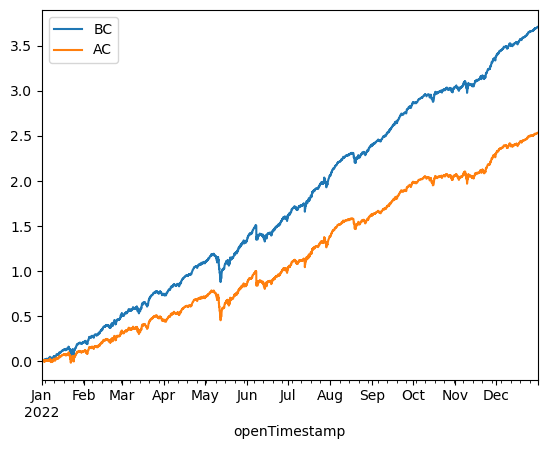

In [648]:
pd.DataFrame({
    'BC' : (holding_pnl+trading_pnl).sum(axis=1),
    'AC' : (holding_pnl+trading_pnl-cost).sum(axis=1)
}).cumsum().plot()

In [645]:
# in particular case of delay == 0
# holding_pnl = init_positions.shift() * close.diff() = (alpha / close).shift() * (close - close.shift()) = alpha.shift() / close.shift() * (close - close.shift()) = alpha.shift() * (close-close.shift())/close.shift() = alpha.shift() * returns
# trading_pnl = (alpha/close).diff() * (close-close) = 0

# for delay = 1
# holding_pnl = init_positions.shift(2) * close.diff() = alpha.shift(2)/close.shift(2) * (close-close.shift()) = alpha.shift(2) * (close-close.shift())/close.shift(2) = alpha.shift(2) * (close-close.shift())/close.shift() * (close.shift()-close.shift(2)+close.shift(2))/close.shift(2) = alpha.shift(2) * returns * (1+returns.shift()) ~= alpha.shift(2) * returns
# trading_pnl = init_positions.shift().diff() * (close-vwap) = (init_positions.shift()-init_positions.shift(2)) * (close-vwap) = (alpha.shift()/close.shift() - alpha.shift(2)/close.shift(2)) * (close-vwap)

Participation rate

In [ ]:
# Calculate participation rate for each instrument for each candle
# For alpha defined above (delay=1), which traded on the booksize = $1mln

In [656]:
booksize = 1e6

partrate = booksize * tvr / features['quoteVolume']

In [661]:
partrate.mean(axis=1)

openTimestamp
2022-01-01 00:00:00+00:00         NaN
2022-01-01 02:00:00+00:00         NaN
2022-01-01 04:00:00+00:00         NaN
2022-01-01 06:00:00+00:00    0.034492
2022-01-01 08:00:00+00:00    0.019767
                               ...   
2022-12-31 14:00:00+00:00    0.045860
2022-12-31 16:00:00+00:00    0.052954
2022-12-31 18:00:00+00:00    0.037083
2022-12-31 20:00:00+00:00    0.061127
2022-12-31 22:00:00+00:00    0.060993
Length: 4380, dtype: float64

In [ ]:
# Idea: think of a function which takes as input (alpha,booksize,max_partrate) and optimizes alpha traded on the `booksize` in a way that participation rate for each instrument for moment in time <= max_partrate

# def optimize_partrate(alpha,booksize,max_partrate)

# Identifiying market regime (bullish or bearish)

In [662]:
features.keys()

dict_keys(['open', 'high', 'low', 'close', 'baseVolume', 'quoteVolume', 'numTrades', 'takerBuyBaseVolume', 'takerBuyQuoteVolume'])

In [663]:
features['close'].index

DatetimeIndex(['2022-01-01 00:00:00+00:00', '2022-01-01 02:00:00+00:00',
               '2022-01-01 04:00:00+00:00', '2022-01-01 06:00:00+00:00',
               '2022-01-01 08:00:00+00:00', '2022-01-01 10:00:00+00:00',
               '2022-01-01 12:00:00+00:00', '2022-01-01 14:00:00+00:00',
               '2022-01-01 16:00:00+00:00', '2022-01-01 18:00:00+00:00',
               ...
               '2022-12-31 04:00:00+00:00', '2022-12-31 06:00:00+00:00',
               '2022-12-31 08:00:00+00:00', '2022-12-31 10:00:00+00:00',
               '2022-12-31 12:00:00+00:00', '2022-12-31 14:00:00+00:00',
               '2022-12-31 16:00:00+00:00', '2022-12-31 18:00:00+00:00',
               '2022-12-31 20:00:00+00:00', '2022-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='openTimestamp', length=4380, freq=None)

In [667]:
# identify for each instrument for each instrument percentage of buyer trades (trades initiated from buyers - so buyers are agressors)

buyer_activity = features['takerBuyQuoteVolume'] / features['quoteVolume']

<AxesSubplot:xlabel='openTimestamp'>

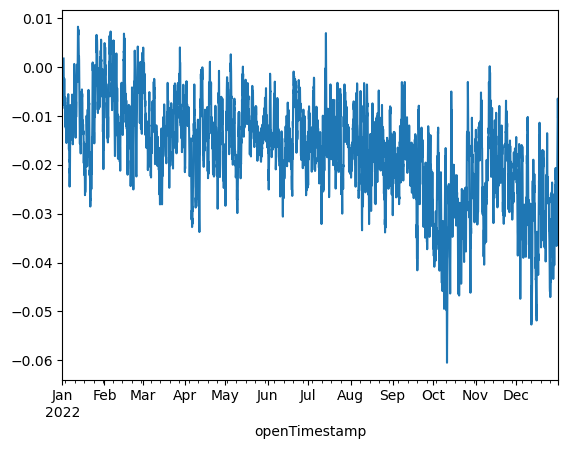

In [672]:
(buyer_activity-0.5).mean(axis=1).rolling(12).mean().plot()